## <span style="color:blue"> Ex 7 - Stefano Schmidt </span>

All the solution to the current exercise are based on class `particle_simulator` developed for sampling from an ensemble of many interacting particle. The basic of the class and the way to use it have been described in the introduction to solution to exercise 4.
The code in **ex_7.cpp** produces the following output files for each of the simulated phase "phasetype":
 - **./out/e_phasetype.out**; **./out/p_phasetype.out**: istantaneous values for pressure and energy for computing autocorrelation
 - **./out/avg_eerr_phasetype.out**; **./out/avg_perr_phasetype.out**: uncertainties of pressure and energy as a function of number of data per block used
 - **./out/avg_phasetype.dat** averages of all the interesting quantities for computing autocorrelation function
 - **./out/hist_NVT_phasetype.dat** histogram of g(r) with uncertainties
 
Three input files has been produced (on for each of the phases) with the required physical conditions. The Montecarlo step has been set manually in such a way that it gives an acceptance rate of 50%. <br>
The simulation lasts $N=30000$ Montecarlo steps. To do more computation is not very feasible and doesn't seem to improve much the results.

### Exercise 7.1
Files **./out/e_phasetype.out** and **./out/p_phasetype.out** are read in input to compute the autocorelation function by the function `get_autocorrelation()` below.<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../particle_simulator/') #to get plot helper
from plot_helper import *

In [2]:
def get_autocorrelation(input_files, times):
    """This functions takes data from input_file and computes the autocorrelation function
    for the times specified in times.
        Input:  input_file (string): keeps filename of the source of the data
                times (n,): keeps the times at which compute autocorrelation function
        Output: autocorr (n,): the value of autocorrelation function for the times specified in times
    """
    data = np.loadtxt(input_files)
    data_avg = np.average(data)
    data_var = np.var(data)
    autocorr = np.zeros(times.shape)
    
    for t in range(np.size(times)):
        cross_term = 0
        avg_t = 0; avg_ret_t =0;
        index = 0
        while t+index < np.size(data):
            cross_term = cross_term + (data[index]*data[t+index])
            avg_t = avg_t + data[index]
            avg_ret_t = avg_ret_t + data[t+index]
            index = index+1
        if index ==0:
            break

        cross_term = cross_term /float(index)
        avg_t = avg_t /float(index)
        avg_ret_t = avg_ret_t /float(index)
        autocorr[t] = (cross_term - avg_t*avg_ret_t )/data_var
    return autocorr

In [3]:
def get_correlation_time(times, autocorr):
    """Returns the correlation time for data as a function of time
    Input:  times (n,): keeps the times at which the autocorrelation function is computed
            autocorr (n,): keeps the value of autocorrelation function
    Output: t_corr (): correlation time (i.e. time s.t data = exp(-times/t_corr))
    """
    from scipy.optimize import curve_fit
    exp_fun = lambda x, t_c: np.exp(-x/t_c)
    popt, pcov = curve_fit(exp_fun, times, autocorr, p0=(1))
    return popt[0]
        
    

In [4]:
def compute_and_plot_autocorrelation_function(times, phase_type=""):
    "Computes and plot the autcorellation functions for energy and pressure in the given phase type."
    #Computing autocorrelation functions
    e_autocorr = get_autocorrelation("./out/e_"+phase_type+".out",times)
    p_autocorr = get_autocorrelation("./out/p_"+phase_type+".out",times)

    #plotting and fitting autocorrelation functions
    t_max_fit = 150

    plt.figure(figsize=(15, 6))
    plt.suptitle("Autocorrelation functions for "+phase_type+" state", size=20)

    #energy
    plt.subplot(1,2,1)
    plt.plot(times, e_autocorr, label="Computed")
    e_t_corr = get_correlation_time(times[0:t_max_fit], e_autocorr[0:t_max_fit])
    plt.plot(times, np.exp(-times/e_t_corr), label ="Fitted (t_c ="+str(np.round(e_t_corr,3))+")")
    plt.xlabel("time")
    plt.ylabel("Autocorellation function")
    plt.legend()
    plt.title("Autocorrelation of energy")


    #pressure
    plt.subplot(1,2,2)
    plt.plot(times, p_autocorr, label="Computed")
    p_t_corr = get_correlation_time(times[0:t_max_fit], p_autocorr[0:t_max_fit])
    plt.plot(times, np.exp(-times/p_t_corr), label ="Fitted (t_c ="+str(np.round(p_t_corr,3))+")")
    plt.xlabel("time")
    plt.ylabel("Autocorellation function")
    plt.legend()
    plt.title("Autocorrelation of pressure")

    plt.show()
    return

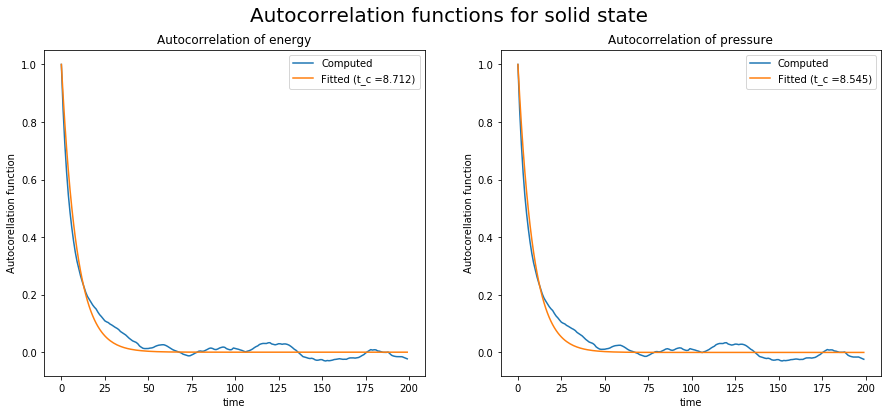

In [5]:
#computing autocorrelations functions
t_max =  200
times = np.arange(0,t_max, step = 1)
compute_and_plot_autocorrelation_function(times,"solid")

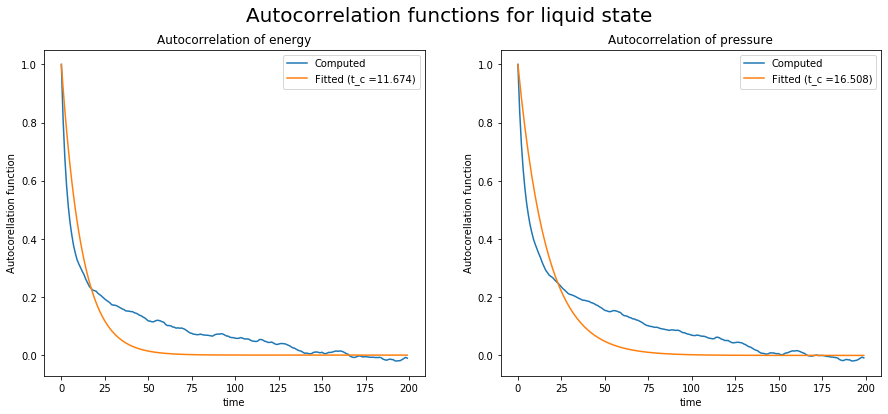

In [6]:
compute_and_plot_autocorrelation_function(times,"liquid")

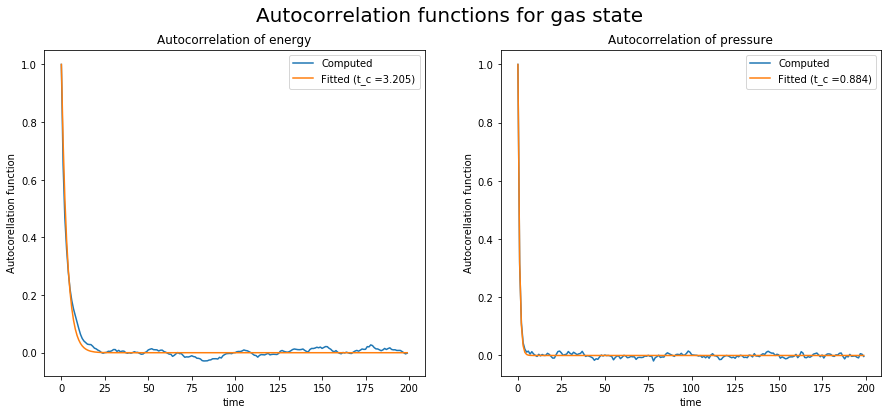

In [7]:
compute_and_plot_autocorrelation_function(times,"gas")

The exponential fit works well. The only heavy disagreement is for the liquid autocorellation function in intermediate times.
The computed correlation time is quite different in the three physical conditions considered: it has been reported on the plot. Liquid phase has the higher correlation time.<br>
The knowledge of correlation time is useful for determining how large should be a block in order to get a realiable estimate of statistical errors. In general this is achieved when different values of block averages are uncorrelated that is when the size of a block is larger (around two or three times) than the correlation time. The same result is obtained below.

Files **./out/avg_e.out** and **./out/avg_p.out** keeps the uncertainties of average quantities (energy and pressure) as a function of L (# of data per block). It has been chosen to set $N_{block}=10$. The plots of data in the files are done below.

In [8]:
def plot_errors(phase_type=""):
    "Plot error vs. L (#data per block) reading input from files."
    e_errors = np.loadtxt("./out/avg_eerr_"+phase_type+".out", dtype=float)
    p_errors = np.loadtxt("./out/avg_perr_"+phase_type+".out", dtype=float)

    plt.figure(figsize=(15, 6))
    plt.suptitle("Errors for "+phase_type+" state", size=20)

    #energy errors
    plt.subplot(1,2,1)
    plt.title("Energy - errors in averages vs L")
    plt.xlabel("L (# data per block)")
    plt.ylabel("Error")
    plt.xscale("log")
    plt.plot(e_errors[:,0],e_errors[:,1])

    #pressure errors
    plt.subplot(1,2,2)
    plt.title("Pressure - errors in averages vs L")
    plt.xlabel("L (# data per block)")
    plt.ylabel("Error")
    plt.xscale("log")
    plt.plot(p_errors[:,0],p_errors[:,1])

    plt.show()
    return

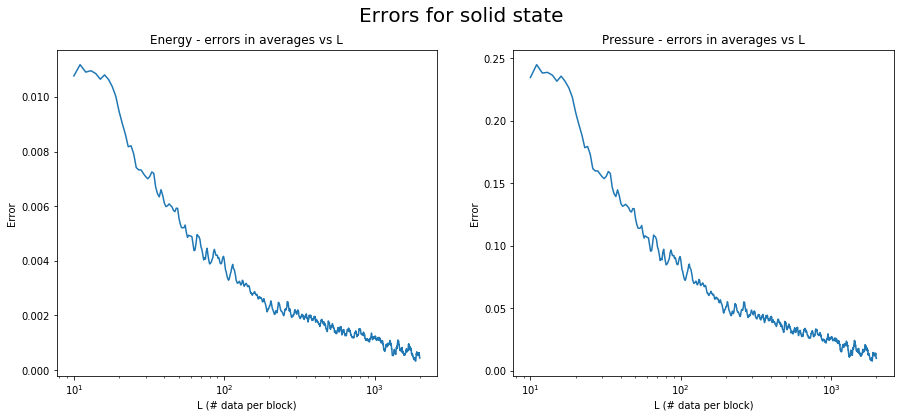

In [9]:
plot_errors("solid")

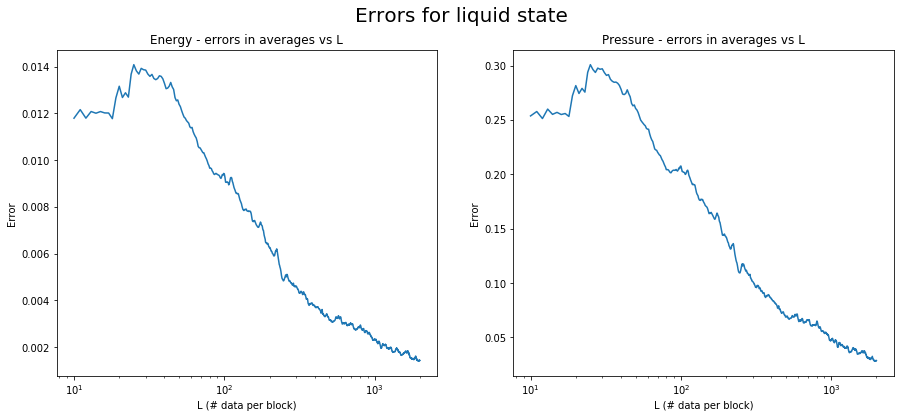

In [10]:
plot_errors("liquid")

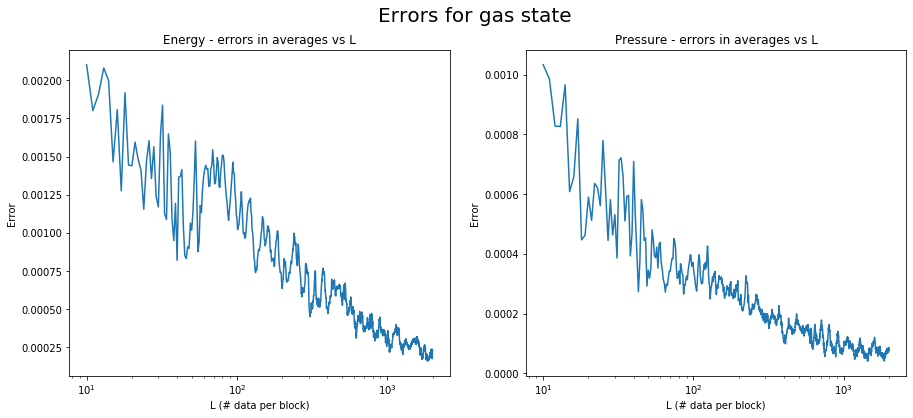

In [11]:
plot_errors("gas")

The overall behaviour of the error as a function of L is as expected monotonically decreasing: this is a consequence of CLT.<br>
However CLT is not valid if data to be averaged are strongly correlated. This happens if $L \gtrsim 2\cdot t_c$ ($t_c$ being the correlation time). In this region the error turns out to be monotonically increasing with L because high correlation between block averages lowers the variance. This means that the value of the uncertainty for small L is underestimated.
This behavour is clearly seen in the liquid case: the position of the "turning point" in the uncertainty plot gives a correlation time $\simeq 30$ which agrees with the one found fitting the autocorrelation function. <br>
For the solid case the behaviour is less clear but still visible as a short plateu in an otherwise monotonically deacresing function. The reason for that is a smaller corellation time for the solid state.<br>
In the gas case the behaviour is not seen at all. This is due to the small corellation time which provides uncorrelated block averages.<br>
The lesson to be learnt here is that, in order to have uncorrelated blocks and thus to be under the validity of CLT, we must choose a number L of data per block which is (quite) bigger of the correlation time.

This limitation over L (although not very serious) can be overcome by random shuffling the order of measures before doing data-blocking. In this way values of two neighbouring blocks are never correlated making CLT valid.

### Exercise 7.4
The class **particle_simulator** provides a method `get_g_hist()` for computing the radial distribution function g(r). The method returns the histogram that divides the size of a box in a number of bins specified in the input file. The codes in **ex_4.cpp** and **ex_7.cpp** print to files **NVE_hist.dat** and **NVT_hist.dat** respectively the values of g(r) in each bin (with variance and standard deviation of average).<br>
The following code is useful to plot the two histograms for g(r). Every histogram is done with $N= 20000$ data points and $n_{bins} = 100$ bins. 

In [12]:
def plot_hist(phase_type=""):
    "Plot histograms of radial function of the given phase type."
    NVT_hist = np.loadtxt("./out/hist_NVT_"+phase_type+".dat")
    NVE_hist = np.loadtxt("../ex_4/out/hist_NVE_"+phase_type+".dat")
    
    plt.figure(figsize=(15, 6))
    plt.suptitle("Histrograms for "+phase_type+" state", size=20)

    #energy errors
    plt.subplot(1,2,1)
    plt.title("Radial function for an NVE system")
    plt.xlabel("r (LJ units)")
    plt.ylabel("")
    plt.errorbar(NVE_hist[:,0],NVE_hist[:,1],xerr=None,yerr=NVE_hist[:,2])

    #pressure errors
    plt.subplot(1,2,2)
    plt.title("Radial function for an NVT system")
    plt.xlabel("r (LJ units)")
    plt.ylabel("")
    plt.errorbar(NVT_hist[:,0],NVT_hist[:,1],xerr=None,yerr=NVT_hist[:,2])

    plt.show()
    return

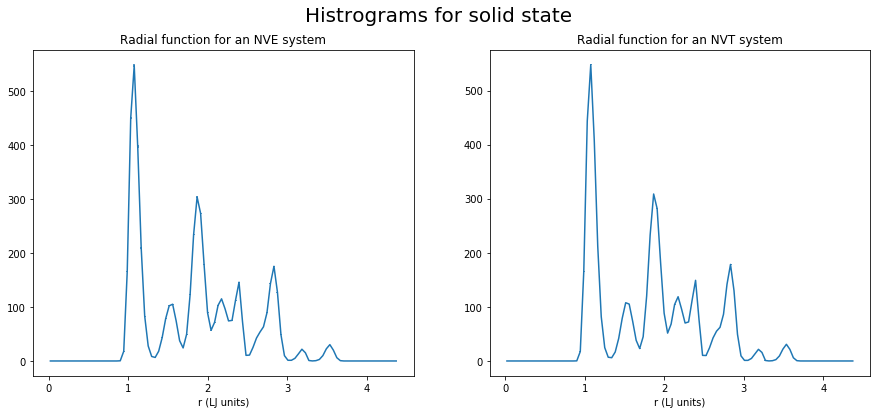

In [13]:
plot_hist("solid")

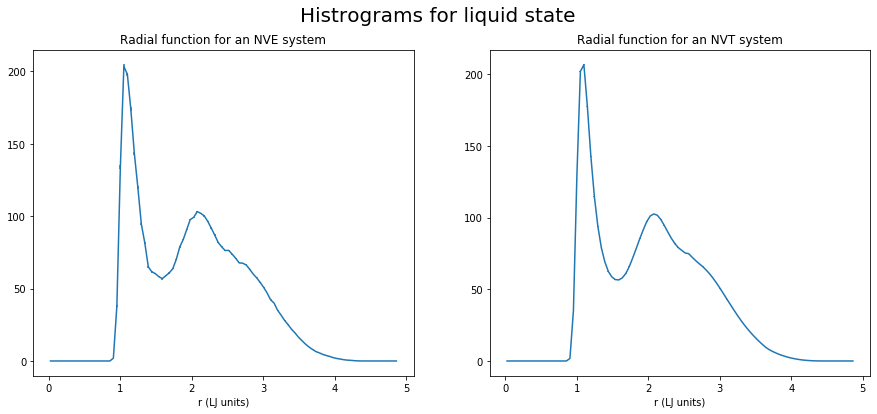

In [14]:
plot_hist("liquid")

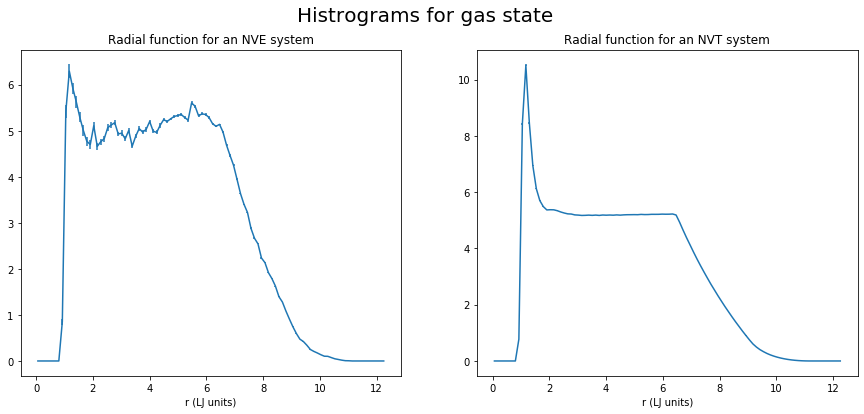

In [15]:
plot_hist("gas")

It is remarkable the agreement between the radial functions obtained in the two different physical situations. The two algorithms exploited for sampling (Verlet and Gibbs/Metropolis) produce the same result!<br>
The agreement is quite impressive in the liquid and solid case. For the gas state the two figures resembles to each other but the agreement is not as precise as for the other states: the peak around r = 1.8 is much lower in NVE simulation. The reason for that might be a lack of statistics in the NVE case which has almost 1/10 of the points of the NVT simulation. As a further confirm of that is the noisy plateau of NVE which doesn't seem to appear to be noisy in the NVT simulation.

Eventually the system is simulated. This is done as previously in exercise 4 plotting some interesting quantities as a function of simulation time. It has been used the function `make_plots()` in file **../particle_simulator/plot_helper.py**: it is the same function used to make plots in exercise 4.<br>
The following plots are obtained for Argon and Krypton.

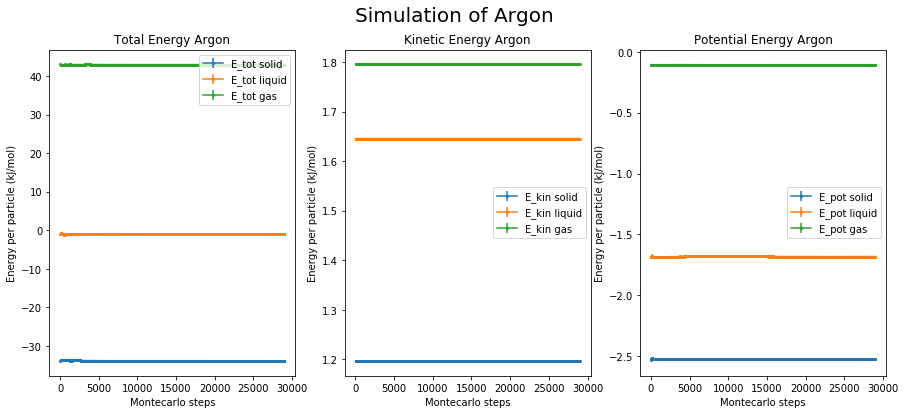

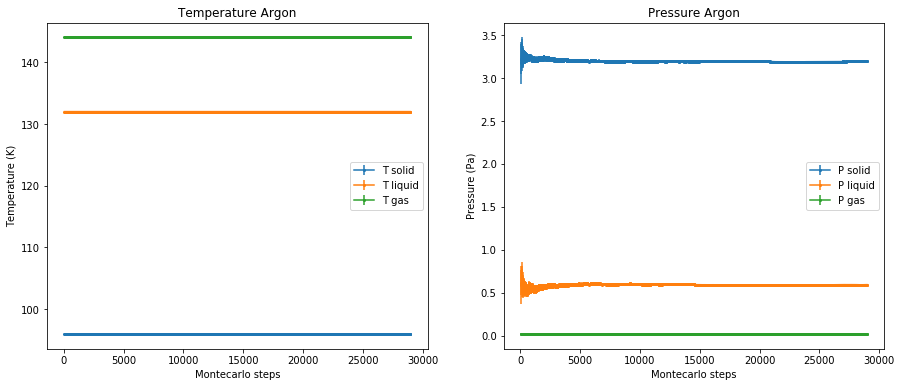

In [16]:
make_plots("Argon", sigma=0.34, epsilon_kb = 120)

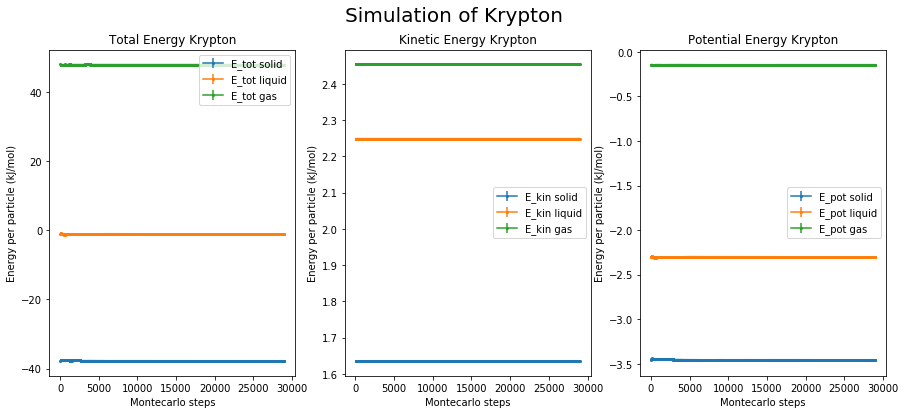

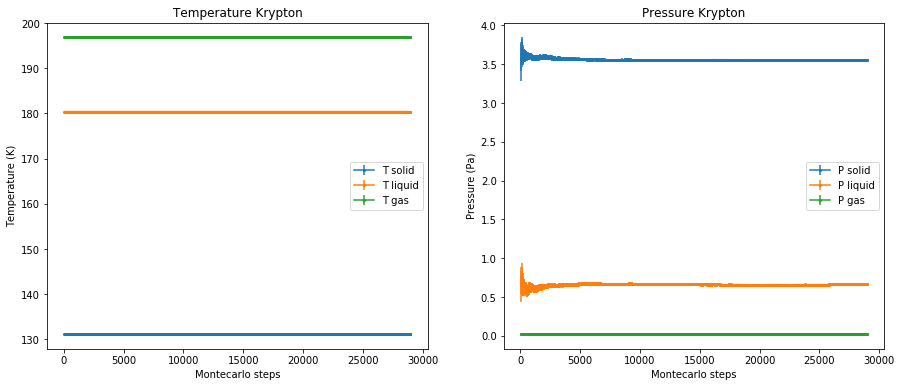

In [17]:
make_plots("Krypton", sigma=0.364, epsilon_kb = 164)

Of course here the temperature and thus the kinetic energy have no uncertainties since the temperature of the system is kepts fixed (NVT).